# tsGT Training



In [1]:
import sys
sys.path.append('code')

import predictors
import inputs
import models
import trainer
import datasets as ds

import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from trax import optimizers
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import trax
import os

2026-01-18 08:34:26.545113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/xristos/miniconda3/envs/jax_legacy/lib/python3.9/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional infor

## Dataset Loading
We can now import the data for training the model. The created synthetic datasets can be found at "data/synthetic_datasets.pkl".


In [2]:
import pickle
with open('data/synthetic_datasets.pkl', 'rb') as file:
    samples = pickle.load(file)

In [3]:
def data_do_df(samples, start_date='2018-01-01 00:00:00', freq='1h'):
    " Utility function to map a dataset to a dataframe with injected covariates. "
    n_signals, length = samples.shape
    df = pd.DataFrame(signals.T)
    df.index = pd.date_range(start_date, periods=length, freq=freq)
    df.index.name = 'date'
    return df

In [5]:
import jax
import jax.numpy as jnp
import time

print("Devices:", jax.devices())
print("Backend:", jax.default_backend())

# Simple matmul test
x = jnp.ones((2000, 2000))
y = jnp.dot(x, x)
y.block_until_ready()

start = time.perf_counter()
for _ in range(100):
    y = jnp.dot(x, x)
y.block_until_ready()
print(f"100 matmuls (2000x2000): {time.perf_counter() - start:.3f}s")

Devices: [GpuDevice(id=0, process_index=0)]
Backend: gpu
100 matmuls (2000x2000): 0.129s


In [7]:
import trax
from trax import layers as tl
import jax.numpy as jnp
import numpy as np
import time

# Test 1: Simple Trax Dense layer
print("=== Testing Trax Layers ===")

x = np.random.randn(32, 128, 256).astype(np.float32)

dense = tl.Dense(256)
dense.init(trax.shapes.signature(x))

# Warmup
out = dense(x)

start = time.perf_counter()
for _ in range(100):
    out = dense(x)
out.block_until_ready()
print(f"Trax Dense (100 calls): {time.perf_counter() - start:.3f}s")


# Test 2: Small Trax transformer
print("\n=== Testing Trax Transformer ===")

small_model = tl.Serial(
    tl.Dense(256),
    tl.Relu(),
    tl.Dense(256),
    tl.LayerNorm(),
)
small_model.init(trax.shapes.signature(x))

# Warmup
out = small_model(x)

start = time.perf_counter()
for _ in range(100):
    out = small_model(x)
out.block_until_ready()
print(f"Trax Serial model (100 calls): {time.perf_counter() - start:.3f}s")


# Test 3: Trax with Accelerate wrapper
print("\n=== Testing Trax Accelerate ===")

accel_model = tl.Accelerate(tl.Serial(
    tl.Dense(256),
    tl.Relu(),
    tl.Dense(256),
    tl.LayerNorm(),
))
accel_model.init(trax.shapes.signature(x))

# Warmup
out = accel_model(x)

start = time.perf_counter()
for _ in range(100):
    out = accel_model(x)
out.block_until_ready()
print(f"Trax Accelerate model (100 calls): {time.perf_counter() - start:.3f}s")


# Test 4: Compare to pure JAX
print("\n=== Testing Pure JAX (for comparison) ===")

from jax import random

key = random.PRNGKey(0)
w1 = random.normal(key, (256, 256))
w2 = random.normal(key, (256, 256))
x_jax = jnp.array(x)

def pure_jax_forward(x, w1, w2):
    x = jnp.dot(x, w1)
    x = jax.nn.relu(x)
    x = jnp.dot(x, w2)
    return x

# Warmup
out = pure_jax_forward(x_jax, w1, w2)
out.block_until_ready()

start = time.perf_counter()
for _ in range(100):
    out = pure_jax_forward(x_jax, w1, w2)
out.block_until_ready()
print(f"Pure JAX (100 calls): {time.perf_counter() - start:.3f}s")


# Test 5: JIT compiled pure JAX
print("\n=== Testing JIT-compiled JAX ===")

import jax
jit_forward = jax.jit(pure_jax_forward)

# Warmup (includes JIT compilation)
out = jit_forward(x_jax, w1, w2)
out.block_until_ready()

start = time.perf_counter()
for _ in range(100):
    out = jit_forward(x_jax, w1, w2)
out.block_until_ready()
print(f"JIT JAX (100 calls): {time.perf_counter() - start:.3f}s")

=== Testing Trax Layers ===
Trax Dense (100 calls): 0.165s

=== Testing Trax Transformer ===
Trax Serial model (100 calls): 0.471s

=== Testing Trax Accelerate ===
Trax Accelerate model (100 calls): 0.095s

=== Testing Pure JAX (for comparison) ===
Pure JAX (100 calls): 0.043s

=== Testing JIT-compiled JAX ===
JIT JAX (100 calls): 0.014s


In [13]:
import trax
from trax import layers as tl
from trax.supervised import training
from trax import optimizers
import numpy as np
import time

# Create simple synthetic data stream
def simple_data_stream():
    while True:
        # Batch of (inputs, targets, weights)
        x = np.random.randn(32, 128, 256).astype(np.float32)
        y = np.random.randn(32, 128, 256).astype(np.float32)
        weights = np.ones((32, 128, 256), dtype=np.float32)
        yield (x, y, weights)

# Simple model
simple_model = tl.Serial(
    tl.Dense(256),
    tl.Relu(),
    tl.Dense(256),
    tl.LayerNorm(),
    tl.Dense(256),
)

# Training task
train_task = training.TrainTask(
    labeled_data=simple_data_stream(),
    loss_layer=tl.L2Loss(),
    optimizer=optimizers.Adam(0.001),
)

# Training loop
loop = training.Loop(
    model=simple_model,
    tasks=[train_task],
    output_dir='./tmp_test_loop',
    eval_tasks=[],
    n_devices=1,
)

# Test 1: First step (includes JIT)
print("=== Trax Training Loop Test ===")
start = time.perf_counter()
loop.run(1)
print(f"First step (with JIT): {time.perf_counter() - start:.2f}s")

# Test 2: Next few steps (compiled)
start = time.perf_counter()
loop.run(10)
print(f"10 steps (compiled): {time.perf_counter() - start:.2f}s")

# Test 3: More steps
start = time.perf_counter()
loop.run(100)
print(f"100 steps (compiled): {time.perf_counter() - start:.2f}s")

print("\nIf 100 steps took < 5s, Trax loop is fine.")
print("Problem is likely your specific model or data pipeline.")

=== Trax Training Loop Test ===
First step (with JIT): 1.37s
10 steps (compiled): 1.06s

Step    200: Ran 89 train steps in 9.44 secs
Step    200: train L2Loss |  1.00869477
100 steps (compiled): 10.56s

If 100 steps took < 5s, Trax loop is fine.
Problem is likely your specific model or data pipeline.


In [14]:
import trax
from trax import layers as tl
from trax.supervised import training
from trax import optimizers
import numpy as np
import time

def simple_data_stream():
    while True:
        x = np.random.randn(32, 128, 256).astype(np.float32)
        y = np.random.randn(32, 128, 256).astype(np.float32)
        weights = np.ones((32, 128, 256), dtype=np.float32)
        yield (x, y, weights)

def make_transformer(n_layers):
    return tl.Serial(
        tl.Dense(256),
        tl.LayerNorm(),
        *[tl.Serial(
            tl.Residual(
                tl.LayerNorm(),
                tl.SelfAttention(n_heads=4, d_qk=64, d_v=64),
                tl.Dropout(0.1),
            ),
            tl.Residual(
                tl.LayerNorm(),
                tl.Dense(512),
                tl.FastGelu(),
                tl.Dense(256),
                tl.Dropout(0.1),
            ),
        ) for _ in range(n_layers)],
        tl.LayerNorm(),
        tl.Dense(256),
    )

# Test with 1, 2, 3, 4 layers
for n_layers in [1, 2, 3, 4]:
    print(f"\n=== {n_layers} Transformer Layer(s) ===")
    
    model = make_transformer(n_layers)
    
    train_task = training.TrainTask(
        labeled_data=simple_data_stream(),
        loss_layer=tl.L2Loss(),
        optimizer=optimizers.Adam(0.001),
    )
    
    loop = training.Loop(
        model=model,
        tasks=[train_task],
        output_dir=f'./tmp_test_{n_layers}layers',
        eval_tasks=[],
        n_devices=1,
    )
    
    start = time.perf_counter()
    loop.run(1)
    jit_time = time.perf_counter() - start
    
    start = time.perf_counter()
    loop.run(10)
    run_time = time.perf_counter() - start
    
    print(f"First step (JIT): {jit_time:.2f}s")
    print(f"10 steps (compiled): {run_time:.2f}s ({run_time/10*1000:.0f}ms/step)")


=== 1 Transformer Layer(s) ===
First step (JIT): 6.95s
10 steps (compiled): 3.36s (336ms/step)

=== 2 Transformer Layer(s) ===
First step (JIT): 13.82s
10 steps (compiled): 5.50s (550ms/step)

=== 3 Transformer Layer(s) ===
First step (JIT): 20.88s
10 steps (compiled): 7.75s (775ms/step)

=== 4 Transformer Layer(s) ===
First step (JIT): 29.08s
10 steps (compiled): 9.60s (960ms/step)


In [15]:
import jax
import numpy as np

x = np.random.randn(32,128,256).astype(np.float32)
y = np.random.randn(32,128,256).astype(np.float32)
w = np.ones((32,128,256), dtype=np.float32)

xb, yb, wb = jax.device_put((x,y,w))

def fixed_stream():
    while True:
        yield (xb, yb, wb)

# Training
We train on different seeds to keep results reproducible. We train 5 models on 5 datasets of each length.

In [4]:
## DEPTH 1

seed = 40

signals = samples["depth1_dataset1"]["data"]
signal_length = 1024
n_signals = int(0.8*len(signals))
n_steps = 5000

start_date = pd.Timestamp('2018-01-01 00:00:00')
freq = '1h'
train_window = 1000     
eval_window = 24         
series_length = 128
batch_size = 32
signals = samples[f"depth1_dataset{1}"]["data"]
df = data_do_df(signals[:n_signals], start_date=start_date, freq=freq)
other_signals = signals[n_signals:]


# Build the dataset
dataset = ds.Dataset(
    data_full=ds.DataCollection(data_loader=lambda: df),
    start_date=start_date,
    train_window=train_window,
    eval_window=eval_window,
    series_length=series_length,
)
# Create the inputs helper.
inputs_iterable = functools.partial(
    inputs.CreateInputs,
    dataset=dataset,
    batch_size=batch_size,
    series_length=series_length,
    weighted_sampling=False,
    traxify=True
)
    # Instantiate body.
model_body = functools.partial(
    models.TransformerBody,
    d_model=256,     
    d_ff_mul=2,
    n_layers=4,         
    n_heads=4,
    max_len=2048,
    dropout=0.1,
    ff_activation=trax.layers.FastGelu,
)
# Instantiate predictor to wrap to model.
predictor_class = functools.partial(
    predictors.SerialPredictor,
    d_in=256,           
    vocab_size=10,      
    precision=3,        
    significance_decay=0.3,  
    low=0.0,
    high=10.0,
    normalization="per_ts",
    normalization_regularizer=0.001
)
loop, predictor = trainer.train(
    output_dir=f'./out/training_result/depth1_dataset{1}',
    inputs=functools.partial(inputs_iterable, full_eval=False),
    model_body=model_body,
    predictor_class=predictor_class,
    optimizer=optimizers.Adam,
    n_steps=2,     
    eval_every=100,
    n_eval_batches=32,
    calc_eval_loss=True,
    seed=seed
)
save = {
    'weights': loop._eval_model.weights,
    'n_steps': n_steps,
    'train_losses': list(loop.history.get('train', 'WeightedCategoryCrossEntropy')),
    'eval_losses': list(loop.history.get('eval', 'WeightedCategoryCrossEntropy')),
    'config': {
        'd_model': 256,
        'n_layers': 4,
        'n_heads':4,
        'vocab_size': 10,
        'precision': 2,
        'significance_decay': 0.3,
    },
    'seed': seed,
    'dataset_idx': 1,
    }
path = f'./out/depth1_dataset{1}_seed{seed}'
os.makedirs(path, exist_ok=True)
with open(f'./out/depth1_dataset{1}_seed{seed}/model_final.pkl', 'wb') as f:
    pickle.dump(save, f)
    
print(f"Saved dataset {1}, seed {seed}")


1. Building Predictor...
Serializer setup took 367.53ms
 Predictor: 3.72ms per call

2. Called Callback...
 Called Callback: 0.03ms per call
 Saved Callback: 0.00ms per call
 Created Model: 0.27ms per call
 Setup Stream: 0.08ms per call
 Setup Train Task: 0.03ms per call
TOTAL=16.1ms
TOTAL=15.7ms
TOTAL=13.9ms
TOTAL=12.7ms
TOTAL=12.5ms
TOTAL=12.3ms
TOTAL=12.5ms
TOTAL=12.1ms
TOTAL=12.2ms
TOTAL=12.6ms
TOTAL=13.4ms
TOTAL=12.8ms
 Setup Loop: 154.21ms per call
TOTAL=13.3ms
TOTAL=12.3ms

Step      1: Total number of trainable weights: 2179850
Step      1: Ran 1 train steps in 41.52 secs
Step      1: train WeightedCategoryCrossEntropy |  2.69181895
TOTAL=22.2ms
TOTAL=21.9ms
Step      1: eval  WeightedCategoryCrossEntropy |  2.31805849
 Ran loop for 2 steps: 748.76ms per call
Saved dataset 1, seed 40


In [7]:
weights = loop.model.weights

In [10]:
context = other_signals[:, :100]   # 100 points of context
predictions = predictor.predict(
    weights=weights,
    context=context,                  # [batch, 100]
    inputs=None,                # [batch, 100 + 50, n_features]
    horizon_length=50,                # Predict 50 steps ahead
)

AxisError: axis 1 is out of bounds for array of dimension 1

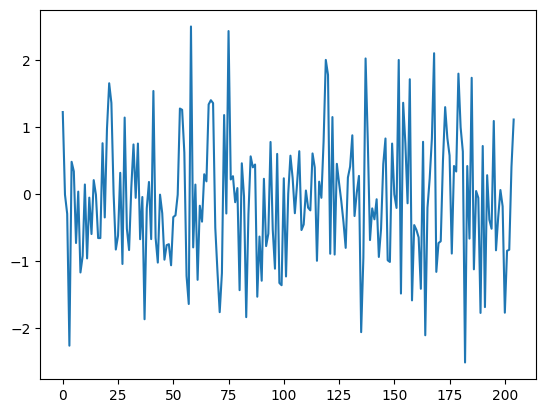

In [15]:
context = other_signals[:, :1]
plt.plot(context)

In [18]:
signals = samples["depth1_dataset1"]["data"]
signals[:1]

array([[ 0.09410349,  0.09578724,  0.0962711 , ..., 36.21894392,
        36.21014612, 36.20354639]])

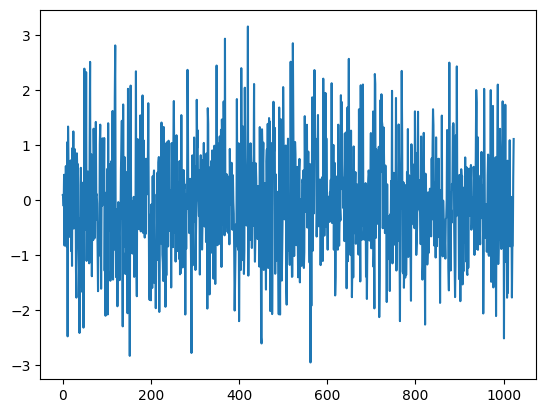

In [20]:
plt.plot(signals[:, :1])

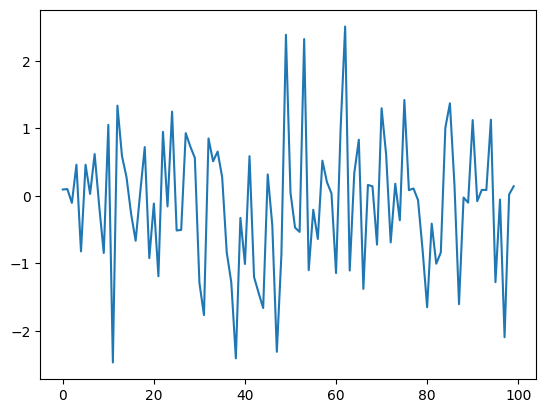

In [22]:
plt.plot(signals[:100, :1])

In [24]:
context = other_signals[:100, :1].T  # [100, batch_size]
batch_size = context.shape[0]
context_length = 100
horizon_length = 50

# Check how many input features your model expects
n_inputs = predictor._n_inputs  # or check your gin config for input_vocab_sizes

# Create dummy inputs if you don't have real covariates
inputs = np.zeros(
    (batch_size, context_length + horizon_length, n_inputs), 
    dtype=np.int32
)

predictions = predictor.predict(
    weights=weights,
    context=context,
    inputs=inputs,
    horizon_length=horizon_length,
)

ValueError: Model was initialized with batch size                 205, but a batch of size 1 was                 received.

In [ ]:
predictor._init_state = None
predictor._batch_size = None
predictor._predict_model = None

# Now predict with your desired batch size
context = other_signals[:1, :100]  # [1, 100] - single time series, 100 timesteps
batch_size = context.shape[0]  # = 1
context_length = context.shape[1]  # = 100
horizon_length = 50

n_inputs = predictor._n_inputs
inputs = np.zeros(
    (batch_size, context_length + horizon_length, n_inputs), 
    dtype=np.int32
)

predictions = predictor.predict(
    weights=weights,
    context=context,
    inputs=inputs,
    horizon_length=horizon_length,
)

In [10]:
batch = loop._tasks[0]._sample_batch
print(f"series shape: {batch[0].shape}")
print(f"inputs shape: {batch[1].shape}")
print(f"target shape: {batch[2].shape}")
print(f"mask shape:   {batch[3].shape}")

series shape: (16, 256)
inputs shape: (16, 256, 4)
target shape: (16, 256)
mask shape:   (16, 256)


In [ ]:
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()

loop.run(50)  # Run 50 steps

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats(30)

In [11]:
# Check if XLA compilation is happening
print(f"JAX backend: {jax.default_backend()}")
print(f"Devices: {jax.devices()}")

# The first step should be slow (compilation), subsequent steps fast
import time
for i in range(5):
    t0 = time.time()
    loop.run(1)
    print(f"Step {i}: {time.time()-t0:.3f}s")

JAX backend: gpu
Devices: [GpuDevice(id=0, process_index=0)]
Step 0: 0.671s
Step 1: 0.671s
Step 2: 0.636s
Step 3: 0.625s
Step 4: 0.615s


In [17]:
print(f"Predictor type: {type(predictor)}")
print(f"Serializer precision: {predictor._serializer._precision if hasattr(predictor, '_serializer') else 'N/A'}")
print(f"Vocab size: {predictor._serializer._vocab_size if hasattr(predictor, '_serializer') else 'N/A'}")

Predictor type: <class 'predictors.serial_predictor.SerialPredictor'>
Serializer precision: 2
Vocab size: 10


In [12]:
import time
import jax.numpy as jnp

def timed_step():
    t0 = time.time()
    loop.run(1)
    # Force sync by accessing a value
    _ = loop.model.weights[0][0][0].block_until_ready()
    return time.time() - t0

# Skip first (compilation)
timed_step()

# Time 5 steps
for i in range(5):
    print(f"Step {i}: {timed_step()*1000:.1f}ms")


Step     62: Ran 1 train steps in 0.65 secs
Step     62: train WeightedCategoryCrossEntropy |  0.38274059
Step     62: eval  WeightedCategoryCrossEntropy |  0.69281638


IndexError: tuple index out of range

# Example time series data

In [ ]:
from itertools import cycle
import random


start_date = pd.Timestamp('2018-01-01 18:30:00')
periods = 2000
train_window = 800 
eval_window = 24
series_length = 256
freq = '1H'


def prepare_example_data(periods, start_date, freq) -> pd.DataFrame:
    t = np.linspace(0, 5 * np.pi, periods)
    frequencies = [0.5, 1, 1.5, 2]
    sine_waves = [np.sin(f * t) for f in frequencies]
    df = pd.DataFrame(sine_waves).T
    df.index = pd.date_range(start_date, periods=periods, freq=freq)
    df.index.name = 'date'
    return df


df = prepare_example_data(periods=periods, start_date=start_date, freq=freq)


def get_list(df, train_window, eval_window, steps, freq):
  start_date = df.index.min()
  end_date = df.index.max() - pd.Timedelta(freq) * (train_window + eval_window)
  delta = ((end_date - start_date) / (steps - 1)).floor(freq)
  return [start_date + i * delta for i in range(steps)]

window_starts = get_list(df, train_window, eval_window, steps=4, freq=freq)

In [ ]:
#################
# Visualization #
#################

plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], color='blue')

unit = pd.Timedelta(freq)
for i, (start, color) in enumerate(zip(window_starts, cycle(["red", "green", "violet"]))):
    plt.axvline(start, color=color, linestyle='-')
    plt.axvline(start + unit * (train_window), color='black', linestyle='--')
    plt.axvline(start + unit * (train_window + eval_window), color=color, linestyle='-')
    plt.axvspan(start, start + unit * (train_window + eval_window), color=color, alpha=0.2)
    plt.text(start + unit * (train_window + eval_window) / 2, 0, f'Window {i + 1}', color=color, ha='center')

    # plot example train samples
    for j in np.linspace(-0.15, 0.15, 5):
        r = random.randint(0, train_window - series_length - eval_window)
        r = unit * r + start      
        plt.plot([r, r + unit * (series_length + eval_window)], [j, j], color='black')
        plt.plot(r, j, marker='|', color='black', markersize=7)
        plt.plot(r + unit * (series_length + eval_window), j, marker='|', color='black', markersize=7)

plt.title('Example time series data', size=15)
plt.xlabel('Timestep', size=10)
plt.ylabel('Value', size=10)

plt.plot([], [], color='blue', label="time series values")
plt.plot([], [], color='black', label="example train samples")
plt.plot([], [], color='black', linestyle='--', label="separation into train window and eval horizon")

plt.legend(loc='lower right')
plt.show()

# Dataset and loader

In [27]:
datasets = [
    ds.Dataset(
        data_full=ds.DataCollection(data_loader=lambda: df),
        start_date=pd.Timestamp(start_date),
        train_window=train_window,
        eval_window=eval_window,
        series_length=series_length,
    ) for start_date in window_starts]

inputs_iterables = [
    functools.partial(
        inputs.CreateInputs,
        dataset=dataset,
        batch_size=16,
        series_length=series_length,
        weighted_sampling=True,
    ) for dataset in datasets]

# Model and predictor

In [28]:
model_body: models.TransformerBody = functools.partial(
    models.TransformerBody,
    d_model=128,
    n_layers=2,
    n_heads=2,
    max_len=100,
    dropout=0.1,
)


# Create the predictor like the paper
predictor_class: predictors.SerialPredictor = functools.partial(
    predictors.SerialPredictor,
    d_in=128,
    vocab_size=10,
    precision=3,
    significance_decay=0.3,
    low=0.0,
    high=1.0,
    normalization="per_ts",
)

# Training: Train tsGT for a few iterations

In [30]:
loops, predictors = [], []

for inputs_iterable in inputs_iterables:
    loop, predictor = trainer.train(
        output_dir='./out',
        inputs=functools.partial(inputs_iterable, full_eval=False),
        model_body=model_body,
        predictor_class=predictor_class,
        optimizer=optimizers.Adam,
        n_steps=1000,
        eval_every=100,
        n_eval_batches=1,
        calc_eval_loss=True,
    )
    loops.append(loop)
    predictors.append(predictor)


Step      1: Total number of trainable weights: 284298
Step      1: Ran 1 train steps in 16.70 secs
Step      1: train WeightedCategoryCrossEntropy |  3.19517469
Step      1: eval  WeightedCategoryCrossEntropy |  4.78960228


KeyboardInterrupt: 

# Simulation

generate simulation data and show a dataframe

In [11]:
import simulations


dfs_sim = [
    simulations.simulate(
        inputs_iterable=functools.partial(inputs_iterable, full_eval=True),
        weights=loop._eval_model.weights,
        predictor=predictor,
        dataset=dataset,
        n_samples=128) 
    for inputs_iterable, predictor, dataset in zip(inputs_iterables, predictors, datasets)
]

dfs_sim[0]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.22s/it]


,index,ts_id,pred_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,gt_3,gt_4,gt_5,gt_6,gt_7,gt_8,gt_9,eval_start,eval_end,horizon
0,0,0.0,0.0,0.029698,0.139042,1.479187,1.261627,1.181349,1.385858,1.183493,...,0.992035,0.986293,0.979014,0.970211,0.959896,0.948087,0.934801,2018-01-03 00:30:00,2018-01-03 19:30:00,10
1,1,0.0,1.0,0.878854,1.036514,1.777695,0.505958,0.631032,1.502319,0.816502,...,0.992035,0.986293,0.979014,0.970211,0.959896,0.948087,0.934801,2018-01-03 00:30:00,2018-01-03 19:30:00,10
2,2,0.0,2.0,0.018159,1.371761,1.345042,1.033024,1.478947,1.607736,1.879495,...,0.992035,0.986293,0.979014,0.970211,0.959896,0.948087,0.934801,2018-01-03 00:30:00,2018-01-03 19:30:00,10
3,3,0.0,3.0,0.997699,1.712703,1.648627,1.032670,0.745010,0.263537,0.709121,...,0.992035,0.986293,0.979014,0.970211,0.959896,0.948087,0.934801,2018-01-03 00:30:00,2018-01-03 19:30:00,10
4,4,0.0,4.0,1.457628,1.495014,1.299825,0.745995,1.430172,0.591585,0.225557,...,0.992035,0.986293,0.979014,0.970211,0.959896,0.948087,0.934801,2018-01-03 00:30:00,2018-01-03 19:30:00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,507,3.0,123.0,0.729932,0.774382,0.627942,0.477754,0.562299,1.453233,1.232291,...,0.483966,0.615523,0.731772,0.829821,0.907232,0.962079,0.992999,2018-01-03 00:30:00,2018-01-03 19:30:00,10
508,508,3.0,124.0,0.001597,1.302657,0.790917,0.964596,0.780886,0.150494,0.017407,...,0.483966,0.615523,0.731772,0.829821,0.907232,0.962079,0.992999,2018-01-03 00:30:00,2018-01-03 19:30:00,10
509,509,3.0,125.0,0.552727,0.135105,0.627688,0.894950,0.018463,0.675243,0.566213,...,0.483966,0.615523,0.731772,0.829821,0.907232,0.962079,0.992999,2018-01-03 00:30:00,2018-01-03 19:30:00,10
510,510,3.0,126.0,0.547476,1.387616,0.660643,0.260866,1.358301,0.578064,1.448504,...,0.483966,0.615523,0.731772,0.829821,0.907232,0.962079,0.992999,2018-01-03 00:30:00,2018-01-03 19:30:00,10


# Evaluate and visualize

In [12]:
import evaluation


train_data = [dataset.train_data for dataset in datasets]

evaluation.evaluate(
    train_data=train_data,
    sim_dataframes=dfs_sim,
    output_dir="./out",
    normalize=None,
    average_preds=False,
)

Finished processing 3 experiments in 0.0070340633392333984 sec.
Computing metrics and predictions...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 125.92it/s]


CRPS computation took  0.005491495132446289
CRPS computation took  0.005190372467041016
CRPS computation took  0.005331993103027344
Finished computing metrics in 0.0264127254486084 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.33it/s]


Plotting p-value strips...
violations.shape=(3, 4, 5, 10)
pof_predictions.shape=(1, 4, 5, 10)
Computing statistics for p_values...
Saving the resulting dict...
Finished plotting in 0.01282191276550293 sec.
Plotting trajectories with violin plots...


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


Finished plotting in 5.917528867721558 sec.
Plotting trajectories with individual histograms...


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

Finished plotting in 3.264321804046631 sec.


Results are stored now in `./out/results/results.pkl`.

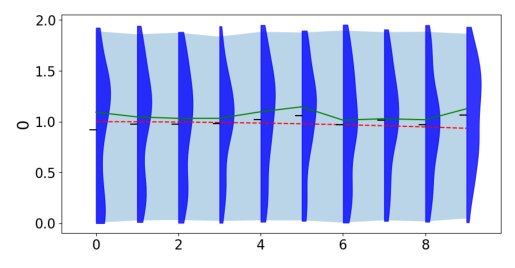

In [13]:
image = "./out/trajectories/trajectory_good_0_0.png"
img = plt.imread(image)

plt.imshow(img)
_ = plt.axis('off')